In [1]:
import straight_axon_model 
import jax.numpy as jnp
import jax

cell_obj = straight_axon_model.StraightAxon()
# Create array of intensities from 0 to 4 with 20 steps
intensities = jnp.linspace(0, 4, 1000)


def stimulate_at_intensity(intensity):
    v_i, m_i, h_i, n_i = cell_obj.jitted_xtra_estim(
        params=cell_obj.params,
        electrode_intensities_uA=jnp.array([intensity, 0.0, 0.0, 0.0])
    )
    return v_i, m_i, h_i, n_i

def is_spike(v_i):
    #print(v_i.shape)
    return jnp.where(jnp.any(v_i[:, 500:] > 0.0), 1, 0)

intensities = []
results = []
spikes = []

lower_bound, upper_bound = 0.0, 4.0

for i in range(20): # Max 20 iterations
    mid = (lower_bound + upper_bound) / 2
    v_i, m_i, h_i, n_i = stimulate_at_intensity(mid)
    spike = is_spike(v_i)
    
    # Store results
    intensities.append(mid)
    results.append((v_i, m_i, h_i, n_i))
    spikes.append(spike)
    
    if spike:
        upper_bound = mid
    else:
        lower_bound = mid
        
        
print(f"Threshold found between {lower_bound:.3f} and {upper_bound:.3f} μA")

intensities = []
results = []
spikes = []

# Add finer resolution stimuli around threshold
threshold_center = (lower_bound + upper_bound) / 2
fine_intensities = jnp.linspace(threshold_center - 0.2, threshold_center + 0.2, 10)

for intensity in fine_intensities:
    v_i, m_i, h_i, n_i = stimulate_at_intensity(intensity)
    spike = is_spike(v_i)
    
    # Store results
    intensities.append(float(intensity))
    results.append((v_i, m_i, h_i, n_i))
    spikes.append(spike)



# Sort results by intensity for plotting
sorted_indices = jnp.argsort(jnp.array(intensities))
intensities = [intensities[i] for i in sorted_indices]
results = [results[i] for i in sorted_indices]
spikes = [spikes[i] for i in sorted_indices]
print(len(intensities))


Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1000 external_states. See `.externals` for details.
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.r

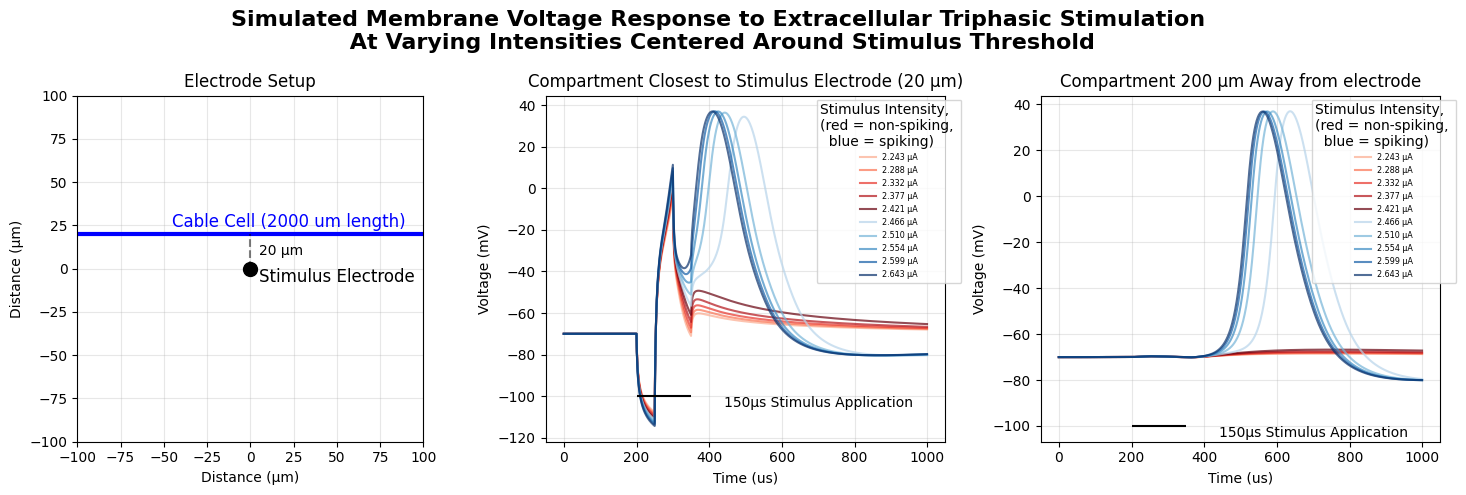

Figure saved as 'three_panel_voltage_response.png'


<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

# Create the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Left panel: Electrode setup
ax1.set_xlim(-100, 100)
ax1.set_ylim(-100, 100)
ax1.set_xlabel('Distance (μm)')
ax1.set_ylabel('Distance (μm)')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Plot electrode at (0,0)
ax1.plot(0, 0, 'ko', markersize=10, label='Electrode')
ax1.text(5, -10, 'Stimulus Electrode', fontsize=12, ha='left', va='bottom')

# Plot cable cell line at y=20
ax1.axhline(y=20, color='blue', linewidth=3, label='Cable Cell')
ax1.text(-45, 22, 'Cable Cell (2000 um length)', fontsize=12, ha='left', va='bottom', color='blue')

# Add distance indicator
ax1.plot([0, 0], [0, 20], 'k--', alpha=0.5)
ax1.text(5, 10, '20 μm', fontsize=10, ha='left', va='center')

ax1.set_title('Electrode Setup')

# Middle panel: Voltage response at compartment 500 (closest to electrode)
# Use existing intensities and results data
time_steps = np.arange(0, len(results[0][0][500, :]), 1)

# Create separate color maps for spiking vs non-spiking traces
spike_colors = plt.cm.Blues(np.linspace(0.3, 1, len([s for s in spikes if s])))
no_spike_colors = plt.cm.Reds(np.linspace(0.3, 1, len([s for s in spikes if not s])))

spike_idx = 0
no_spike_idx = 0
colors = []
for spike in spikes:
    if spike:
        colors.append(spike_colors[spike_idx])
        spike_idx += 1
    else:
        colors.append(no_spike_colors[no_spike_idx]) 
        no_spike_idx += 1

# Plot first 1000 microseconds (convert time steps to microseconds)


# Plot voltage traces for compartment 500
for i, (intensity, color) in enumerate(zip(intensities, colors)):
    voltage_trace = results[i][0][500, 0:1000]  # Voltage at compartment 500
    ax2.plot(voltage_trace, color=color, alpha=0.7, 
             label=f'{intensity:.3f} μA')
# Add horizontal line and label for stimulus duration
ax2.hlines(y=-100, xmin=200, xmax=350, colors='black', linestyles='-', alpha=1.0)
ax2.text(700, -100, "150μs Stimulus Application", ha='center', va='top', fontsize=10)


ax2.set_xlabel('Time (us)')
ax2.set_ylabel('Voltage (mV)')
ax2.set_title('Compartment Closest to Stimulus Electrode (20 μm)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper right', title='Stimulus Intensity, \n(red = non-spiking, \n  blue = spiking)', fontsize='xx-small')
ax2.grid(True, alpha=0.3)

# Right panel: Voltage response at compartment 700 (200 μm away)
# Plot voltage traces for compartment 700
for i, (intensity, color) in enumerate(zip(intensities, colors)):
    voltage_trace = results[i][0][700, 0:1000]  # Voltage at compartment 600
    ax3.plot(voltage_trace, color=color, alpha=0.7, 
             label=f'{intensity:.3f} μA')

# Add dark horizontal line and label for stimulus duration
ax3.hlines(y=-100, xmin=200, xmax=350, colors='black', linestyles='-', alpha=1.0)
ax3.text(700, -100, "150μs Stimulus Application", ha='center', va='top', fontsize=10)


ax3.set_xlabel('Time (us)')
ax3.set_ylabel('Voltage (mV)')
ax3.set_title('Compartment 200 μm Away from electrode')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper right', title='Stimulus Intensity, \n(red = non-spiking, \n  blue = spiking)', fontsize='xx-small')
ax3.grid(True, alpha=0.3)

# Set the super title
fig.suptitle('Simulated Membrane Voltage Response to Extracellular Triphasic Stimulation\n At Varying Intensities Centered Around Stimulus Threshold', 
             fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('three_panel_voltage_response.png', dpi=300, bbox_inches='tight')
print("Figure saved as 'three_panel_voltage_response.png'")

10


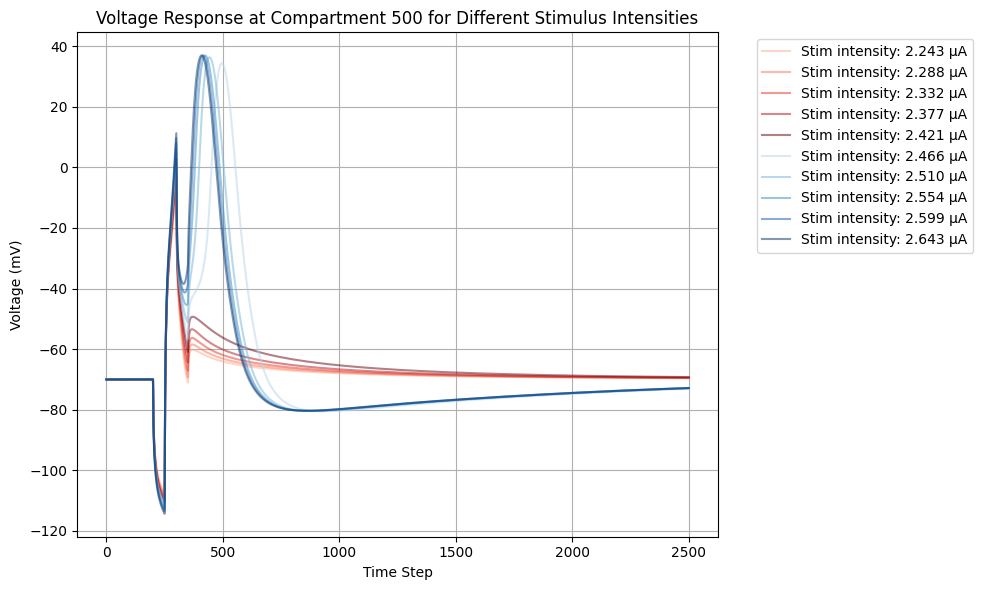

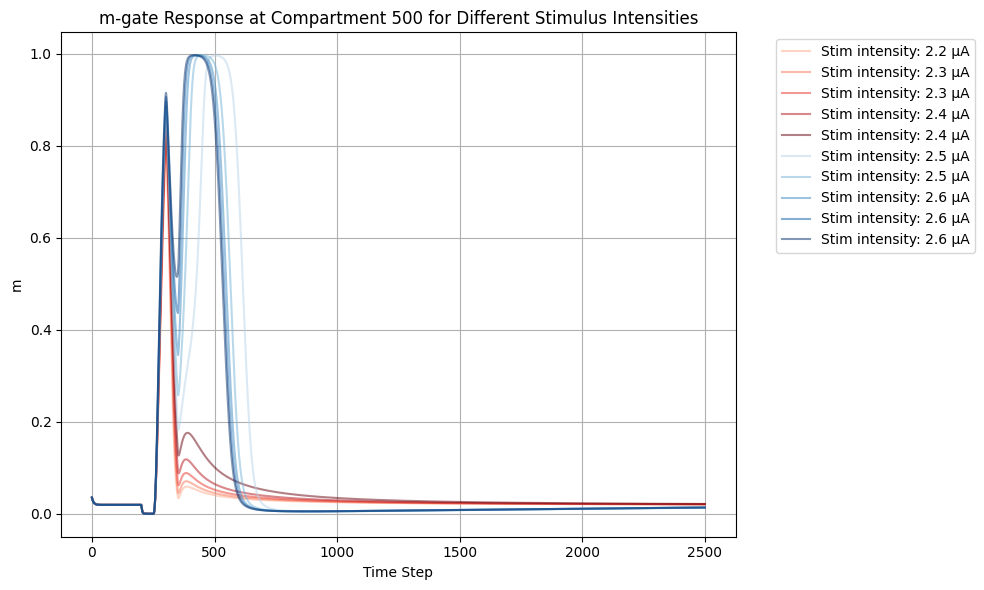

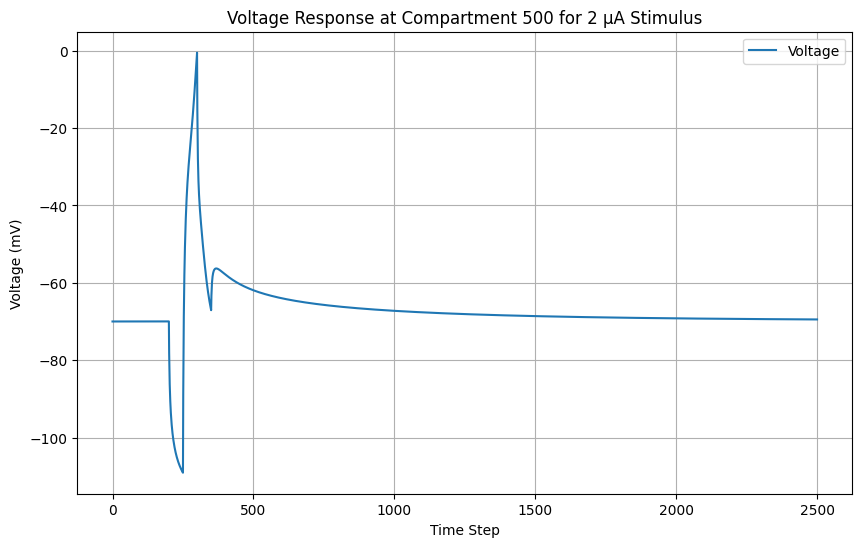

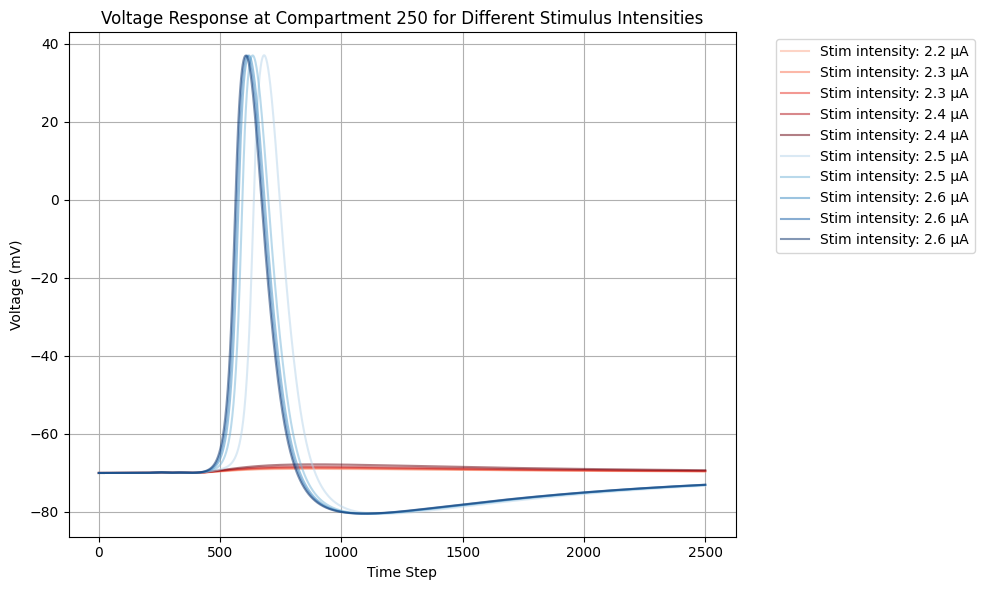

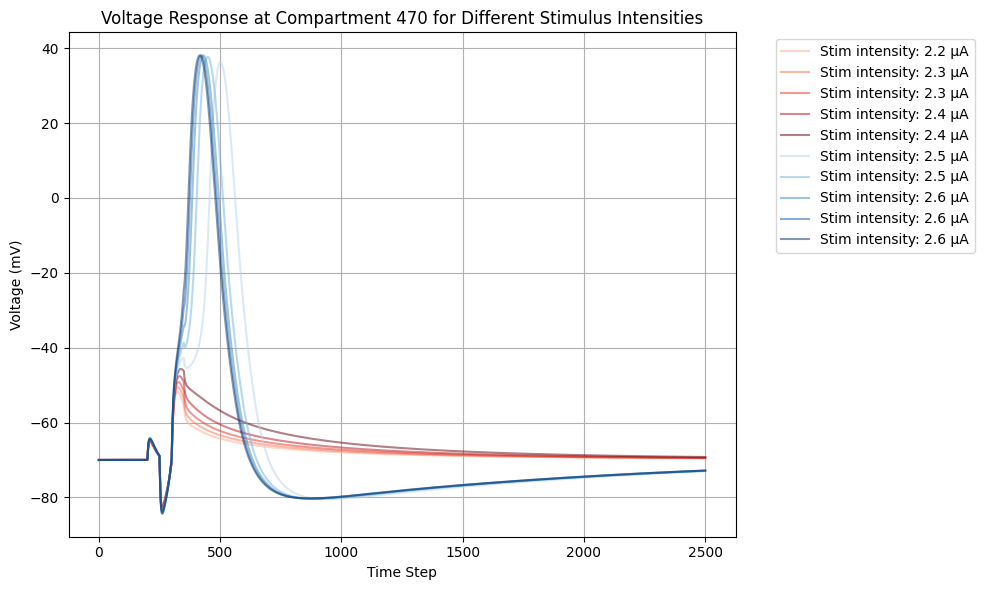

In [8]:
import matplotlib.pyplot as plt
import numpy as np




print(len(intensities))
# Extract voltage traces for compartment 500 across all intensities
v500_traces = [result[0][500,:] for result in results]
# Create separate color maps for spiking vs non-spiking traces
spike_colors = plt.cm.Blues(np.linspace(0.3, 1, len([s for s in spikes if s])))
no_spike_colors = plt.cm.Reds(np.linspace(0.3, 1, len([s for s in spikes if not s])))

spike_idx = 0
no_spike_idx = 0
colors = []
for spike in spikes:
    if spike:
        colors.append(spike_colors[spike_idx])
        spike_idx += 1
    else:
        colors.append(no_spike_colors[no_spike_idx]) 
        no_spike_idx += 1

plt.figure(figsize=(10,6))
for i, (trace, intensity) in enumerate(zip(v500_traces, intensities)):
    plt.plot(trace, color=colors[i], alpha=0.5, 
             label=f'Stim intensity: {intensity:.3f} μA')

plt.xlabel('Time Step')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Response at Compartment 500 for Different Stimulus Intensities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract m traces for compartment 500 across all intensities
m500_traces = [result[1][500,:] for result in results]

plt.figure(figsize=(10,6))
for i, (trace, intensity) in enumerate(zip(m500_traces, intensities)):
    plt.plot(trace, color=colors[i], alpha=0.5,
             label=f'Stim intensity: {intensity:.1f} μA')

plt.xlabel('Time Step')
plt.ylabel('m')
plt.title('m-gate Response at Compartment 500 for Different Stimulus Intensities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract voltage and m traces for compartment 500 at intensity 2
intensity_2_idx = 2
v500_intensity2 = results[intensity_2_idx][0][500,:]
m500_intensity2 = results[intensity_2_idx][1][500,:]

plt.figure(figsize=(10,6))
plt.plot(v500_intensity2, label='Voltage')
plt.xlabel('Time Step')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Response at Compartment 500 for 2 μA Stimulus')
plt.grid(True)
plt.legend()
plt.show()


# Extract voltage traces for compartment 250 across all intensities
v250_traces = [result[0][250,:] for result in results]

plt.figure(figsize=(10,6))
for i, (trace, intensity) in enumerate(zip(v250_traces, intensities)):
    plt.plot(trace, color=colors[i], alpha=0.5,
             label=f'Stim intensity: {intensity:.1f} μA')

plt.xlabel('Time Step')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Response at Compartment 250 for Different Stimulus Intensities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Extract voltage traces for compartment 490 across all intensities
v470_traces = [result[0][470,:] for result in results]

plt.figure(figsize=(10,6))
for i, (trace, intensity) in enumerate(zip(v470_traces, intensities)):
    plt.plot(trace, color=colors[i], alpha=0.5,
             label=f'Stim intensity: {intensity:.1f} μA')

plt.xlabel('Time Step')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Response at Compartment 470 for Different Stimulus Intensities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()





In [3]:
import matplotlib.pyplot as plt

# Plot currents at specified compartments
plt.figure(figsize=(10,6))
plt.plot(v[490,:], label='Compartment 490')
plt.plot(v[510,:], label='Compartment 510') 
plt.plot(v[500,:], label='Compartment 500')

plt.plot(v[400,:], label='Compartment 400')
plt.plot(v[600,:], label='Compartment 600')
plt.plot(v[0,:], label='Compartment 0')

plt.xlabel('Time Step')
plt.ylabel('Current')
plt.title('Currents at Different Compartments')
plt.legend()
plt.grid(True)
plt.show()


# Plot m at specified compartments
plt.figure(figsize=(10,6))
plt.plot(m[490,:], label='Compartment 490')
plt.plot(m[510,:], label='Compartment 510')
plt.plot(m[500,:], label='Compartment 500')
plt.plot(m[400,:], label='Compartment 400')
plt.plot(m[600,:], label='Compartment 600')
plt.plot(m[0,:], label='Compartment 0')

plt.xlabel('Time Step')
plt.ylabel('m')
plt.title('m at Different Compartments')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'v' is not defined

<Figure size 1000x600 with 0 Axes>

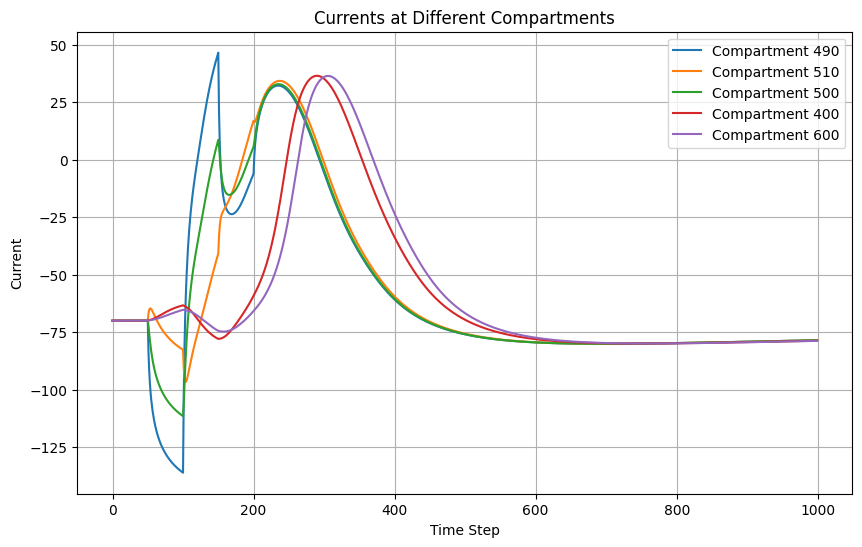

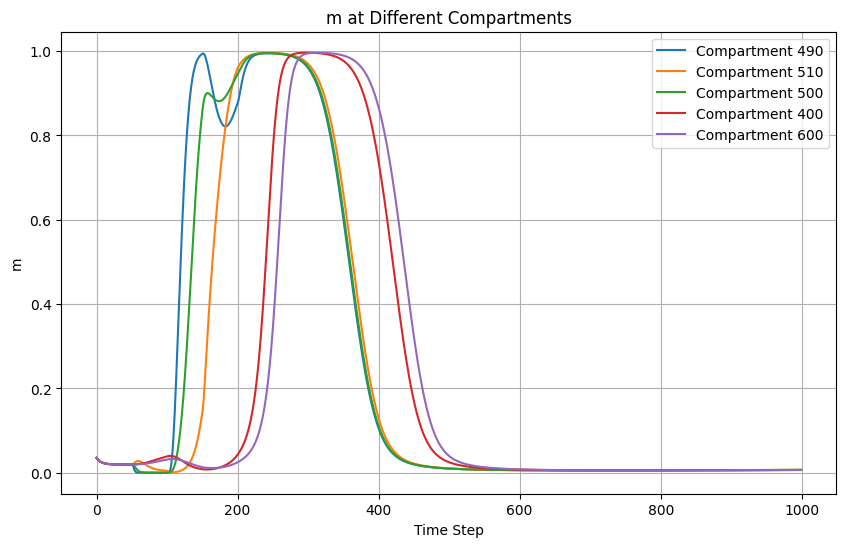